# Statystyka praktyczna w data science (Python)
# Rozdział 4. Regresja i predykcja
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Importuje wymagane pakiety Pythona.

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [3]:
%matplotlib inline

Definiuje ścieżki do zestawów danych. Jeżeli przechowujesz dane w innym katalogu, wprowadź poniżej stosowne zmiany.

In [4]:
DATA = Path('.').resolve().parents[1] / 'dane'

LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

# Prosta regresja liniowa
## Równanie regresji

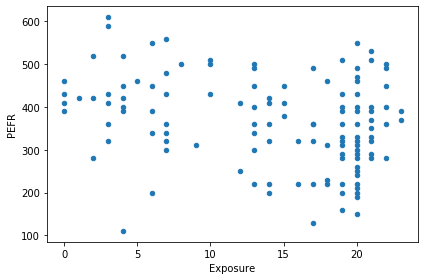

In [5]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

Możemy użyć modelu `LinearRegression` z pakietu _scikit-learn_.

In [6]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Wyraz wolny: {model.intercept_:.3f}')
print(f'Współczynnik ekspozycji: {model.coef_[0]:.3f}')

Wyraz wolny: 424.583
Współczynnik ekspozycji: -4.185


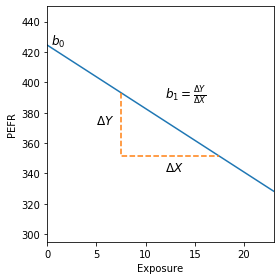

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

## Dopasowanie wartości i rezydua
Metoda `predict` dopasowanego modelu _scikit-learn_ służy do przewidywania nowych punktów danych.

In [8]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

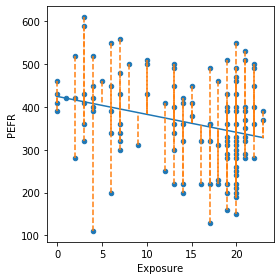

In [9]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

# Regresja wieloraka

In [10]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [11]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Wyraz wolny: {house_lm.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Wyraz wolny: -521924.722
Współczynniki:
 SqFtTotLiving: 228.83210707277883
 SqFtLot: -0.06050600921030867
 Bathrooms: -19438.0989597891
 Bedrooms: -47781.15337702313
 BldgGrade: 106117.20955540464


## Ocena modelu
Pakiet _Scikit-learn_ zawiera różne wskaźniki określające jakość modelu. Korzystamy tu z miary `r2_score`.

In [12]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261210
r2: 0.5407


Pakiet _scikit-learn_ zawiera wiele różnych wskaźników, natomiast w pakiecie _statsmodels_ dostępna jest dokładniejsza analiza modelu regresji liniowej. W pakiecie tym można określić model na dwa różne sposoby: jeden z nich przypomina technikę stosowaną w pakiecie _scikit-learn_, a drugi pozwala na tworzenie wzorów w stylu _R_. Skorzystamy tu z pierwszego rozwiązania. Pakiet _statsmodels_ nie dodaje automatycznie członu wolnego, dlatego musimy dołączyć do predyktorów stałą kolumnę z wartością 1. W tym celu możemy skorzystać z pakietu _pandas_.

In [13]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     5340.
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:22:24   Log-Likelihood:            -3.1520e+05
No. Observations:               22689   AIC:                         6.304e+05
Df Residuals:                   22683   BIC:                         6.305e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8321      3.898     58.699

## Dobór modelu i regresja krokowa

In [14]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2772.
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:23:00   Log-Likelihood:            -3.1378e+05
No. Observations:               22689   AIC:                         6.276e+05
Df Residuals:                   22676   BIC:                         6.277e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

Możemy użyć metody `stepwise_selection` z pakietu _dmba_.

In [15]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Wyraz wolny: {best_model.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=648047.41, constant
Step: score=633068.91, add SqFtTotLiving
Step: score=630847.73, add BldgGrade
Step: score=628284.84, add YrBuilt
Step: score=627838.21, add Bedrooms
Step: score=627656.24, add Bathrooms
Step: score=627579.79, add PropertyType_Townhouse
Step: score=627579.23, add SqFtFinBasement
Step: score=627579.13, add PropertyType_Single Family
Step: score=627579.13, unchanged None

Wyraz wolny: 6177658.144
Współczynniki:
 SqFtTotLiving: 199.2747421754513
 BldgGrade: 137181.137246268
 YrBuilt: -3564.9348704151344
 Bedrooms: -51974.76845567933
 Bathrooms: 42403.0599996767
 PropertyType_Townhouse: 84378.93333640494
 SqFtFinBasement: 7.0321789175372205
 PropertyType_Single Family: 22854.879540193


## Regresja ważona
Możemy obliczyć rok (Year) z kolumny daty za pomocą wyrażeń listowych lub metody `apply` ramki danych.

In [16]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.832107,245.017268
1,SqFtLot,-0.060506,-0.292429
2,Bathrooms,-19438.098960,-26079.171065
3,Bedrooms,-47781.153377,-53625.403756
4,BldgGrade,106117.209555,115259.025694
5,intercept,-521924.722038,-584265.243910


In [18]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123719.461859    107053.509750  2014
2     59172.380809     96215.311258  2006
3    190114.526168    187016.303746  2007
4    198773.408711    196094.133435  2008
5     91759.120528     84251.737522  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140543.441174,146560.172470
1,2007,147750.250745,152851.205703
2,2008,142089.652601,146363.379906
3,2009,146985.714371,151126.140107
4,2010,163269.337297,166366.412082
5,2011,169939.305067,172952.873763
6,2012,169408.081997,171758.039475
7,2013,203661.023940,206242.942433
8,2014,184452.698962,186668.270255
9,2015,172319.935476,169836.728491


# Zmienne skategoryzowane w regresji
## Zmienne fikcyjne

In [19]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [20]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [21]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [22]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Wyraz wolny: {house_lm_factor.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Wyraz wolny: -446878.742
Współczynniki:
 SqFtTotLiving: 223.37386435242863
 SqFtLot: -0.07041335666275902
 Bathrooms: -15973.13495239739
 Bedrooms: -50900.59614025566
 BldgGrade: 109426.22297987368
 PropertyType_Single Family: -84691.37983985741
 PropertyType_Townhouse: -115147.08567736203


## Zmienne skategoryzowane na wielu poziomach

In [23]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98354  98050  98057  98288  98224  98043  89118  98068  9800   \
ZipCode  ...      9      7      4      4      3      1      1      1      1   

         98113  
ZipCode      1  

[1 rows x 82 columns]


In [24]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    17
1    16
2    16
3    16
4    17
Name: ZipGroup, dtype: int64


In [25]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

# Interpretacja równania regresji
## Predyktory skorelowane

Wyniki regresji krokowej:

In [26]:
print(f'Wyraz wolny: {best_model.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Wyraz wolny: 6177658.144
Współczynniki:
 SqFtTotLiving: 199.2747421754513
 BldgGrade: 137181.137246268
 YrBuilt: -3564.9348704151344
 Bedrooms: -51974.76845567933
 Bathrooms: 42403.0599996767
 PropertyType_Townhouse: 84378.93333640494
 SqFtFinBasement: 7.0321789175372205
 PropertyType_Single Family: 22854.879540193


In [27]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Wyraz wolny: {reduced_lm.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Wyraz wolny: 4913024.933
Współczynniki:
 Bedrooms: 27136.353706663085
 BldgGrade: 249018.92971838027
 YrBuilt: -3211.3003463311393
 PropertyType_Single Family: -19931.584509017088
 PropertyType_Townhouse: -47424.27442030179


## Zmienne zakłócające

In [28]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Wyraz wolny: {confounding_lm.intercept_:.3f}')
print('Współczynniki:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Wyraz wolny: -665438.171
Współczynniki:
 SqFtTotLiving: 210.81988745251618
 SqFtLot: 0.46107503104771314
 Bathrooms: 5733.885836833621
 Bedrooms: -41773.87384820903
 BldgGrade: 98718.96235962417
 PropertyType_Single Family: 19189.602732479005
 PropertyType_Townhouse: -78310.22583037535
 ZipGroup_1: 51678.9958803444
 ZipGroup_2: 114029.53827781476
 ZipGroup_3: 176233.51095932658
 ZipGroup_4: 336165.6552494437


## Interakcje i zjawiska główne

In [29]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3241.
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:36:47   Log-Likelihood:            -3.1103e+05
No. Observations:               22689   AIC:                         6.221e+05
Df Residuals:                   22673   BIC:                         6.222e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

> Wyniki różnią się od R z powodu różnych technik tworzenia przedziałów. Wymuszenie takich samych przedziałów powoduje uzyskiwanie takich samych rezultatów.

# Testowanie założeń: diagnostyka regresji
## Wartości odstające

Pakiet _statsmodels_ zawiera najlepiej rozwinięte metody analizy wartości odstających.

In [30]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 11 Nov 2020   Prob (F-statistic):          1.69e-103
Time:                        17:39:10   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

Klasa `OLSInfluence` jest inicjalizowana wraz z wynikami regresji OLS i daje dostęp do wielu przydatnych własności. Wykorzystujemy tu studentyzowane rezydua.

In [31]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078567


In [32]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115835


In [33]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms           3
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


## Obserwacje wpływowe

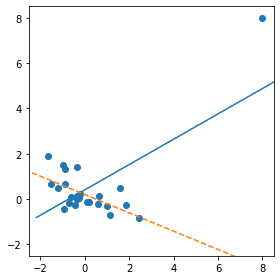

In [34]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Oblicza współrzędne prostej na podstawie nachylenia i wyrazu wolnego"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

Pakiet _statsmodel_ zawiera różne wykresy analizujące wpływ punktów danych.

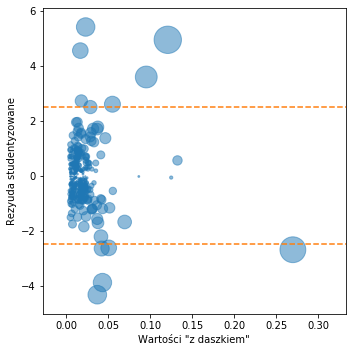

In [35]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('Wartości "z daszkiem"')
ax.set_ylabel('Rezyuda studentyzowane')

plt.tight_layout()
plt.show()

In [36]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedastyczność, anormalność i błędy skorelowane

Metoda `regplot` z pakietu _seaborn_ umożliwia dołączanie wygładzonej krzywej do wykresu punktowego.

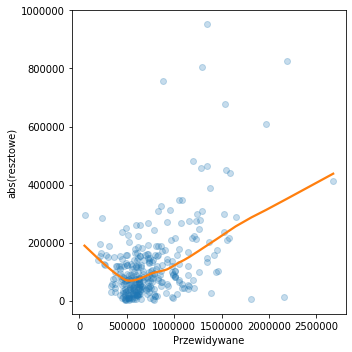

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(result_98105.fittedvalues, np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('Przewidywane')
ax.set_ylabel('abs(resztowe)')

plt.tight_layout()
plt.show()

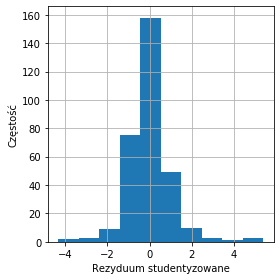

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('Rezyduum studentyzowane')
ax.set_ylabel('Częstość')


plt.tight_layout()
plt.show()

## Wykresy częściowych rezyduów i nieliniowość

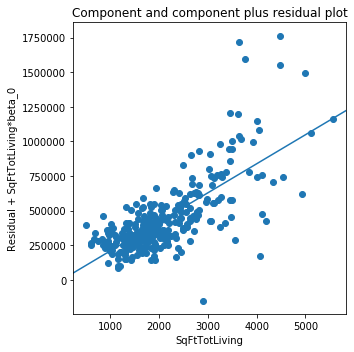

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

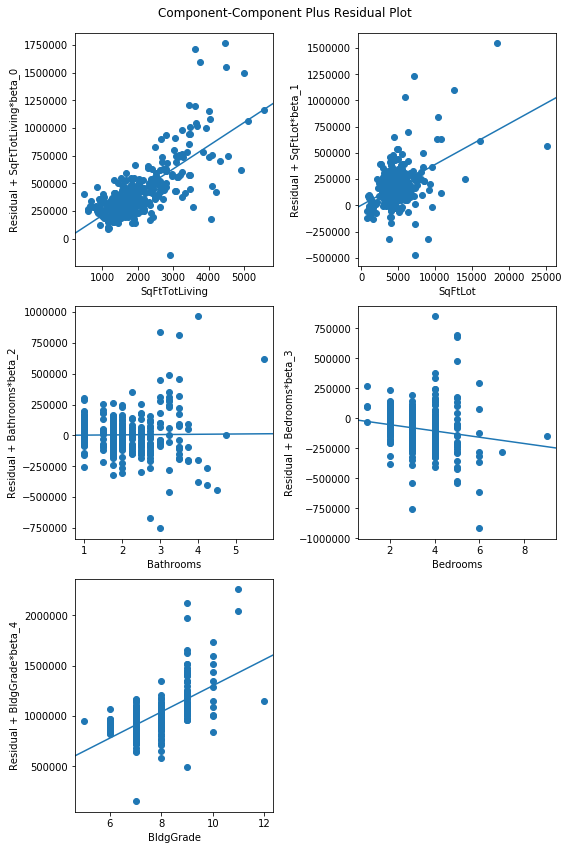

In [40]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## Regresja wielomianowa i regresja sklejana

In [41]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Wed, 11 Nov 2020   Prob (F-statistic):          9.95e-106
Time:                        17:48:05   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Implementacja wykresu rezyduów cząstkowych z pakietu statsmodels działa jedynie z członem liniowym. Poniżej prezentujemy implementację, która, chociaż niewydajna, działa z regresją wielomianową.

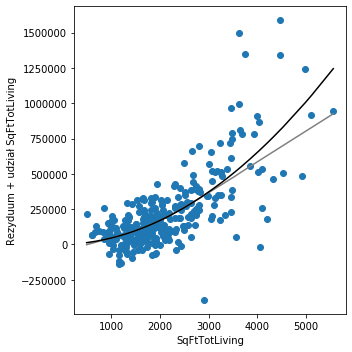

0.03879128168237239


In [42]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Rezyduum + udział {feature}')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Funkcja sklejana

In [43]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Wed, 11 Nov 2020   Prob (F-statistic):          7.10e-104
Time:                        17:50:36   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


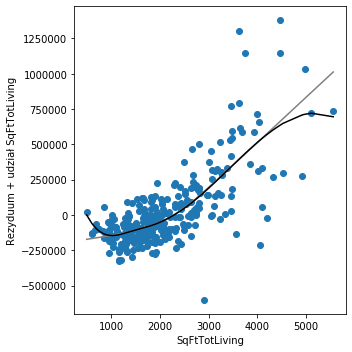

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

## Uogólnione modele addytywne

In [45]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1708
                                                Scale:                                    29480381715.8322
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

C:\Users\Krzysztof\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  # Remove the CWD from sys.path while we load stuff.


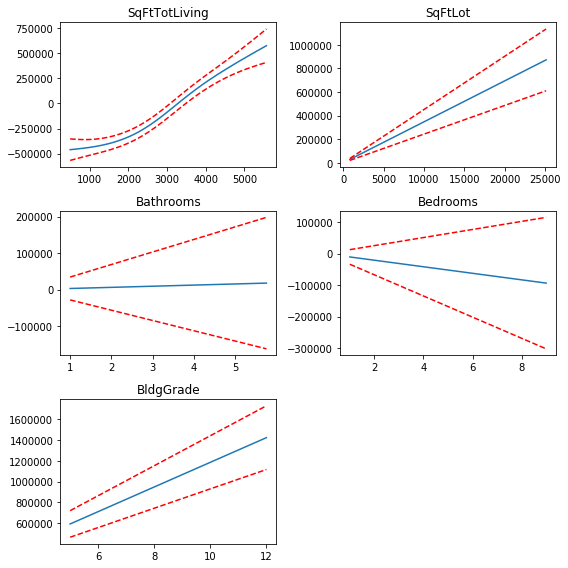

In [46]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Materiały dodatkowe - nieopisane w książce
# Regularyzacja
## Lasso

In [47]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [48]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [49]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [50]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)


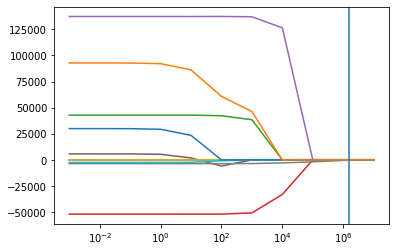

In [51]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [52]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,289.075580
1,SqFtLot,0.029421
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.248074
7,YrBuilt,-0.000000
8,YrRenovated,45.734639
9,NewConstruction,-0.000000


In [52]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308